In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

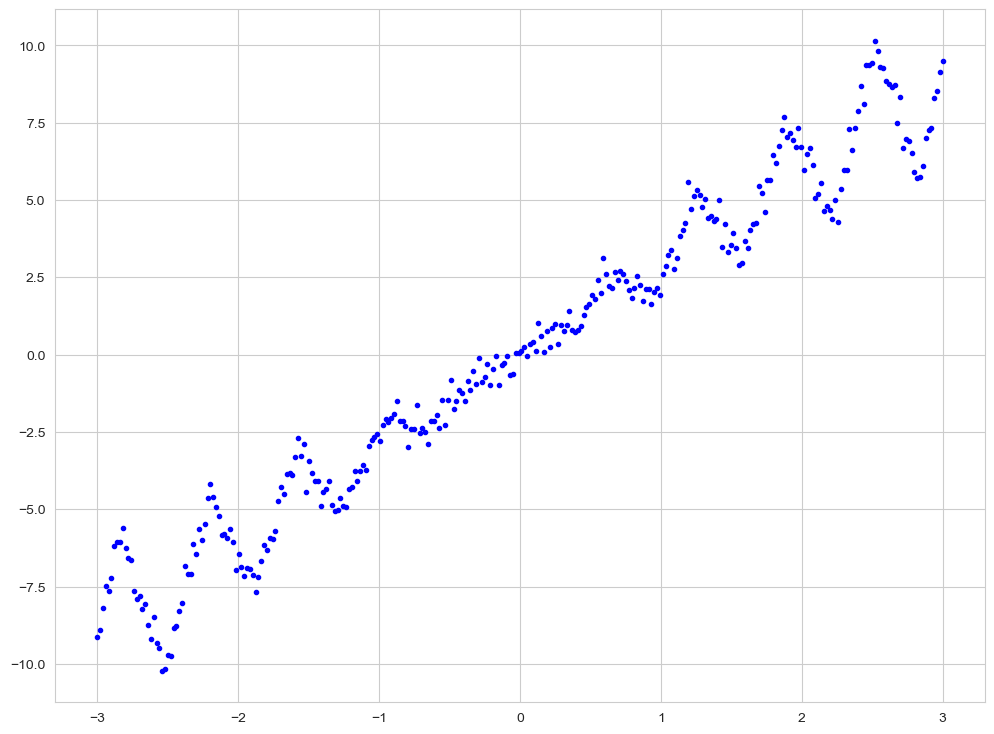

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

Max Depth: 1, MSE: 7.23, Variance: 19.92
Max Depth: 3, MSE: 0.89, Variance: 26.26
Max Depth: 5, MSE: 0.20, Variance: 26.95
Max Depth: 7, MSE: 0.05, Variance: 27.10
Max Depth: 10, MSE: 0.00, Variance: 27.15
Max Depth: 15, MSE: 0.00, Variance: 27.15


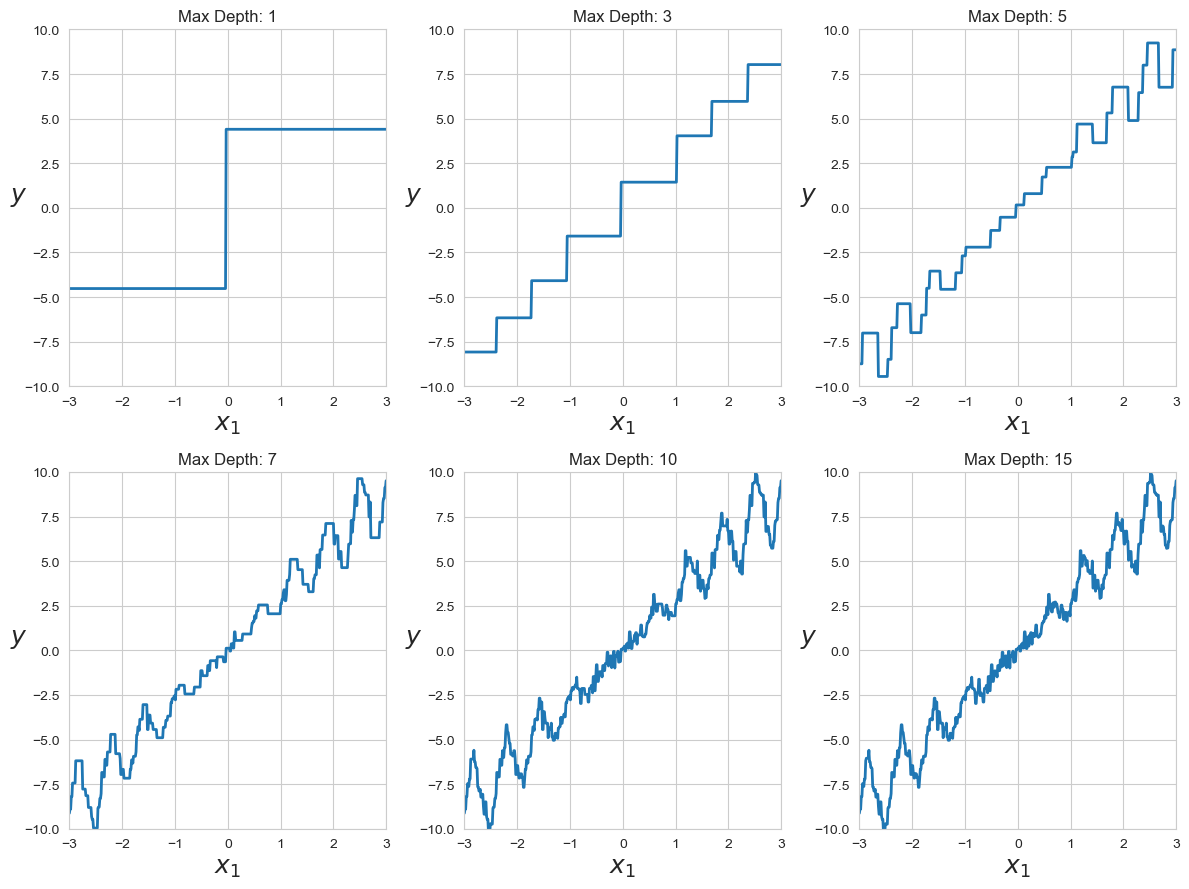

In [5]:
depths = [1, 3, 5, 7, 10, 15]
plt.figure(figsize=(12, 9))

for depth in depths:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
    tree_reg.fit(X, y)
    
    plt.subplot(2, 3, depths.index(depth) + 1)
    plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")
    plt.title(f"Max Depth: {depth}")
    
    y_pred = tree_reg.predict(X)
    mse = mean_squared_error(y, y_pred)
    variance = np.var(y_pred)
    
    print(f"Max Depth: {depth}, MSE: {mse:.2f}, Variance: {variance:.2f}")

plt.tight_layout()
plt.show()

Оптимальная глубина равняется 10. При увеличении максимальной глубины модель лучше подстраивается под обучающие данные.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

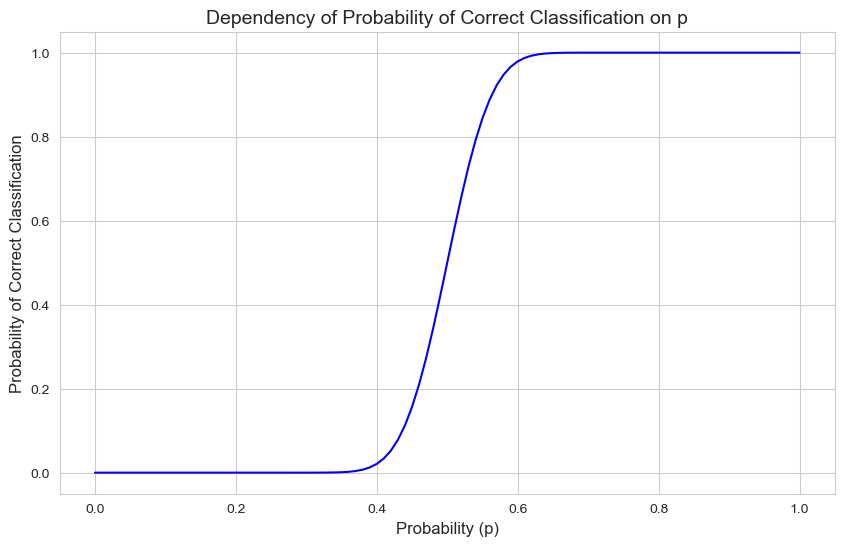

In [6]:
# Функция для вычисления вероятности правильной классификации объекта
def calculate_accuracy(p):
    mu = 0
    for i in range(51, 102):
        mu += np.math.comb(101, i) * (p ** i) * ((1 - p) ** (101 - i))
    return mu

# Значения p от 0 до 1 с шагом 0.01
p_values = np.linspace(0, 1, 101)

# Вычисление вероятности правильной классификации для каждого значения p
accuracies = [calculate_accuracy(p) for p in p_values]

# график
plt.figure(figsize=(10, 6))
plt.plot(p_values, accuracies, color='blue')
plt.xlabel('Probability (p)', fontsize=12)
plt.ylabel('Probability of Correct Classification', fontsize=12)
plt.title('Dependency of Probability of Correct Classification on p', fontsize=14)
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

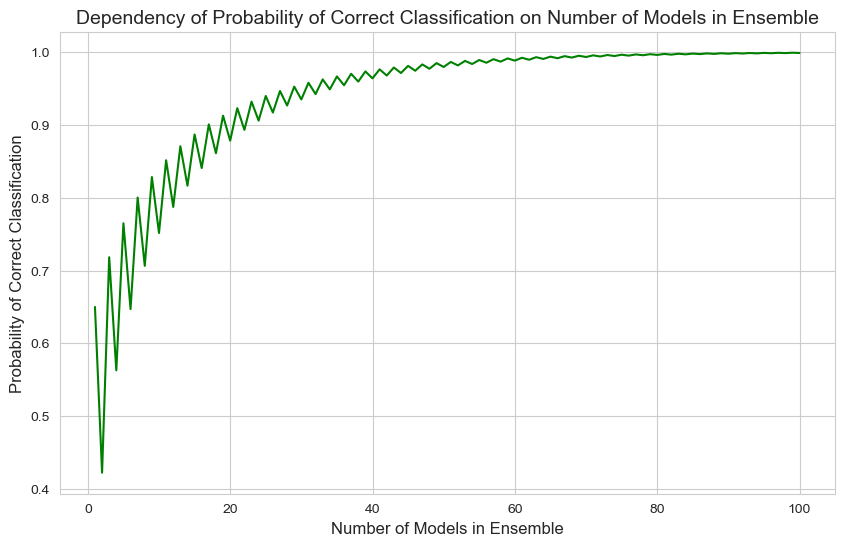

In [7]:
# Функция для вычисления вероятности правильной классификации объекта в ансамбле моделей
def ensemble_accuracy(p, num_models):
    mu = 0
    for i in range(num_models // 2 + 1, num_models + 1):
        mu += np.math.comb(num_models, i) * (p ** i) * ((1 - p) ** (num_models - i))
    return mu

# Фиксированная вероятность p = 0.65
p = 0.65

# Число моделей в ансамбле от 1 до 100
num_models_values = np.arange(1, 101)

# Вычисление вероятности правильной классификации для каждого числа моделей
accuracy_values = [ensemble_accuracy(p, num_models) for num_models in num_models_values]

# график
plt.figure(figsize=(10, 6))
plt.plot(num_models_values, accuracy_values, color='green')
plt.xlabel('Number of Models in Ensemble', fontsize=12)
plt.ylabel('Probability of Correct Classification', fontsize=12)
plt.title('Dependency of Probability of Correct Classification on Number of Models in Ensemble', fontsize=14)
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* Вероятность правильной классификации возрастает с увеличением значения p. 
* С увеличением числа моделей вероятность правильной классификации также увеличивается.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            
            indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            X_bootstrap = X[indices][:, feat_ids]
            y_bootstrap = y[indices]
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for i, tree in enumerate(self.trees):
            feat_ids = self.feat_ids_by_tree[i]
            probas += tree.predict_proba(X[:, feat_ids])
        
        return probas / len(self.trees)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

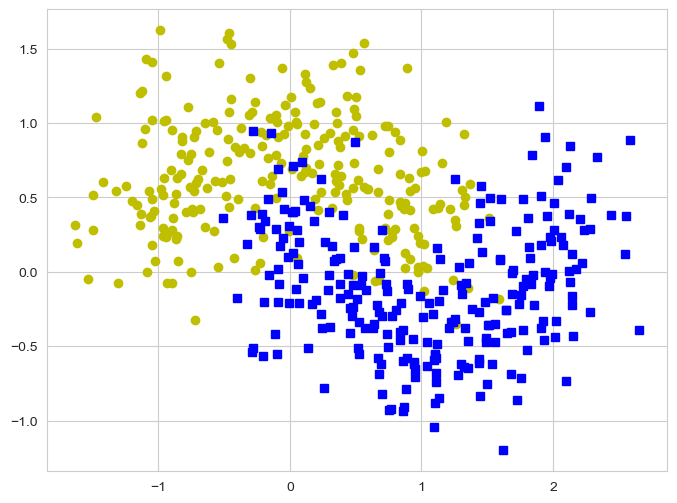

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

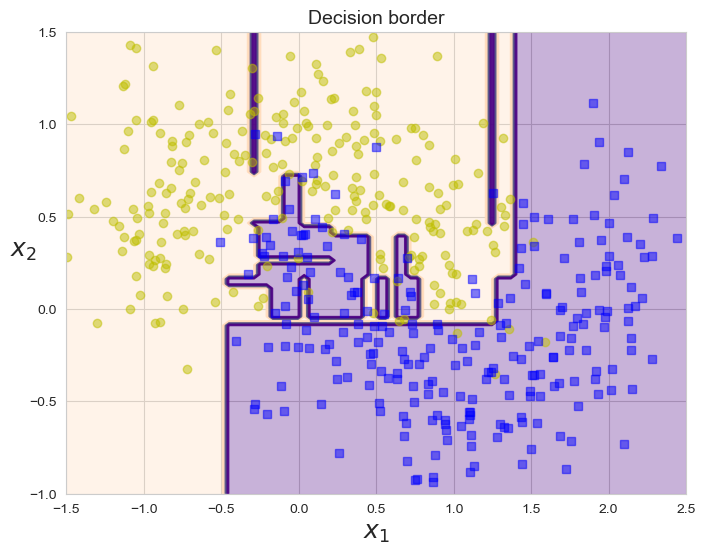

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


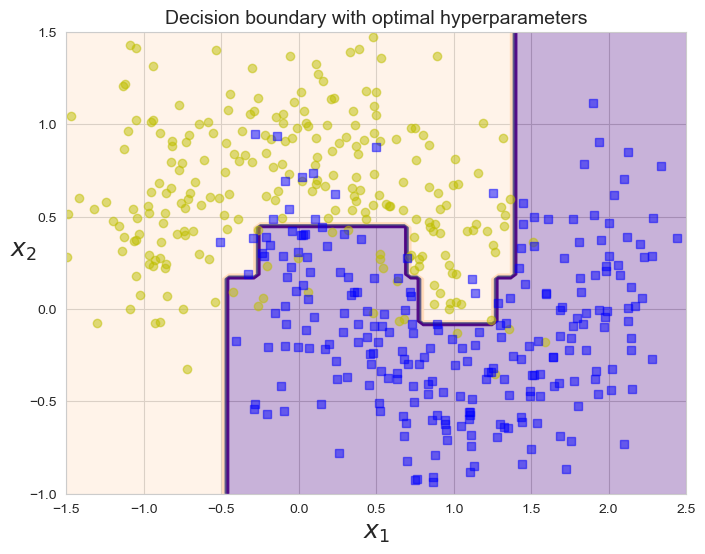

In [12]:
# Определяем набор гиперпараметров для подбора
param_grid = {
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5, 10]
}

# Создаем экземпляр модели
clf = DecisionTreeClassifier(random_state=42)

# Используем GridSearchCV для подбора лучших параметров
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Best hyperparameters:", grid_search.best_params_)

# Визуализируем разделяющую границу с оптимальными параметрами
best_clf = grid_search.best_estimator_
plt.figure(figsize=(8, 6))
plot_decision_boundary(best_clf, X, y)
plt.title("Decision boundary with optimal hyperparameters", fontsize=14)
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [13]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [14]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
max_features_values = [1, 2, 4, 6, 8, 10, 20, 'sqrt', 'log2']
correlations = []

for max_features_value in max_features_values:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features_value, random_state=42)
    rf.fit(X_train, y_train)
    correlations.append(base_model_pair_correlation(rf, X_test))

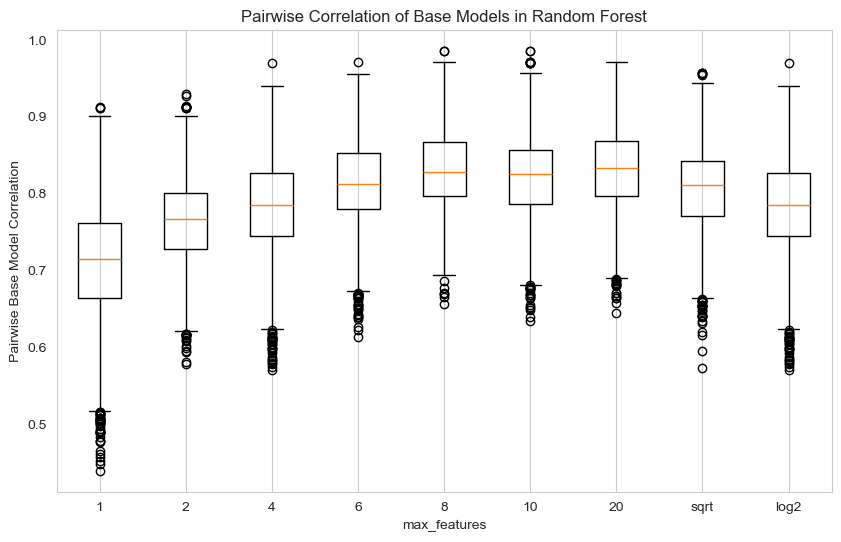

In [20]:
plt.figure(figsize=(10, 6))
plt.boxplot(correlations, labels=max_features_values)
plt.xlabel('max_features')
plt.ylabel('Pairwise Base Model Correlation')
plt.title('Pairwise Correlation of Base Models in Random Forest')
plt.grid(axis='y')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

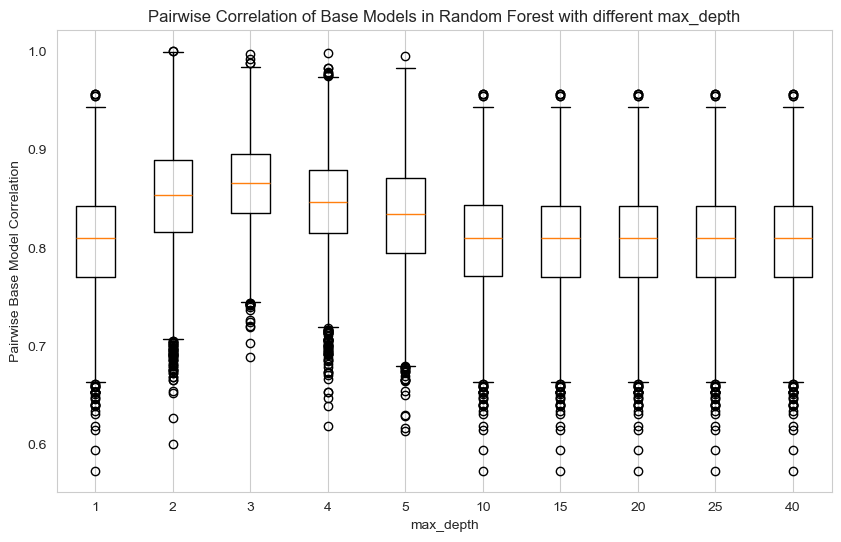

In [23]:
max_depth_values = [None, 2, 3, 4, 5, 10, 15, 20, 25]
correlations_depth = []

for max_depth_value in max_depth_values:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth_value, random_state=42)
    rf.fit(X_train, y_train)
    correlations_depth.append(base_model_pair_correlation(rf, X_test))

plt.figure(figsize=(10, 6))
plt.boxplot(correlations_depth, labels=max_depth_values)
plt.xlabel('max_depth')
plt.ylabel('Pairwise Base Model Correlation')
plt.title('Pairwise Correlation of Base Models in Random Forest with different max_depth')
plt.grid(axis='y')
plt.show()

Опишите ваши наблюдения:

* При `max_features < 8` корреляция увеличивается, при более высоких значениях она остается неизменной.
* Параметр `max_depth` почти не влияет на корреляцию, однако при `max_depth`=2, 3, 4, 5 наблюдаются небольшие колебания.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [60]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("data/heart.csv")

"gdown" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [61]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [26]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [27]:
# Создание VotingClassifier с жестким голосованием
voting_hard = VotingClassifier(estimators=base_models, voting='hard')

# Создание VotingClassifier с мягким голосованием
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [28]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    estimators = ensemble.named_estimators_
    
    for (name1, est1), (name2, est2) in combinations(estimators.items(), 2):
        if hasattr(est1, "predict_proba"):
            ypred_t1 = est1.predict_proba(X)[:, 1]
        elif hasattr(est1, "decision_function"):
            ypred_t1 = est1.decision_function(X)
        else:
            raise RuntimeError(f"Estimator {name1} does not support probabilistic predictions.")

        if hasattr(est2, "predict_proba"):
            ypred_t2 = est2.predict_proba(X)[:, 1]
        elif hasattr(est2, "decision_function"):
            ypred_t2 = est2.decision_function(X)
        else:
            raise RuntimeError(f"Estimator {name2} does not support probabilistic predictions.")

        corrs.append((name1, name2, pearsonr(ypred_t1, ypred_t2)[0]))
    return corrs

In [29]:
# Обучаем ансамбль с жестким голосованием
voting_hard.fit(X_train, y_train)

# Вычисляем корреляции
correlations_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [30]:
# Выводим корреляции в порядке убывания
sorted_correlations_hard = sorted(correlations_hard, key=lambda x: x[2], reverse=True)

for name1, name2, corr_value in sorted_correlations_hard:
    print(f"Correlation between {name1} and {name2}: {corr_value}")

Correlation between SVC_LIN and LR: 0.9858524521524874
Correlation between LGBM and XGB: 0.9708386932644943
Correlation between CAT and LGBM: 0.955278131308783
Correlation between ETC and CAT: 0.9527199736215166
Correlation between RF and CAT: 0.9450698035153569
Correlation between CAT and XGB_RF: 0.9423509286571877
Correlation between RF and XGB_RF: 0.9381993826431192
Correlation between CAT and XGB: 0.9339896537953176
Correlation between LGBM and XGB_RF: 0.9337741786662473
Correlation between LGBM_RF and XGB_RF: 0.9324490601648507
Correlation between XGB and XGB_RF: 0.9294030810885919
Correlation between RF and ETC: 0.9215651183028868
Correlation between RF and LGBM: 0.9146873011990888
Correlation between RF and LGBM_RF: 0.9146686698479997
Correlation between ETC and XGB_RF: 0.9011248608496558
Correlation between RF and XGB: 0.8966406293216899
Correlation between ETC and LGBM: 0.8928745278265376
Correlation between ETC and SVC_LIN: 0.8924651069527857
Correlation between LR and NB: 0.

In [32]:
# порог корреляции в 0.9
correlation_threshold = 0.9

# Получим имена моделей с корреляцией выше порога
highly_correlated_models = set()
for name1, name2, corr_value in sorted_correlations_hard:
    if corr_value > correlation_threshold:
        highly_correlated_models.add(name1)
        highly_correlated_models.add(name2)

# Создадим новый список моделей для ансамбля, исключив модели с высокой корреляцией
reduced_base_models = [(name, model) for name, model in base_models if name not in highly_correlated_models]

# Создадим новый ансамбль VotingClassifier с мягким голосованием
voting_reduced_soft = VotingClassifier(estimators=reduced_base_models, voting='soft')

# Обучим новый ансамбль и оценим его качество
voting_reduced_soft.fit(X_train, y_train)
scores_reduced_soft = cross_val_score(voting_reduced_soft, X_train, y_train, cv=3, scoring="f1")
print(f"Reduced VotingClassifier (soft) F1 score: {scores_reduced_soft.mean()}")

# hard голосование
voting_reduced_hard = VotingClassifier(estimators=reduced_base_models, voting='hard')
voting_reduced_hard.fit(X_train, y_train)
scores_reduced_hard = cross_val_score(voting_reduced_hard, X_train, y_train, cv=3, scoring="f1")
print(f"Reduced VotingClassifier (hard) F1 score: {scores_reduced_hard.mean()}")


Reduced VotingClassifier (soft) F1 score: 0.8281949018992778
Reduced VotingClassifier (hard) F1 score: 0.7585218646088211


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [33]:
data = pd.read_csv("data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [34]:
# Общая информация о данных
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [35]:
# Проверим наличие пропущенных значений
print(data.isnull().sum())

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64


В датасете отсутствуют пропущенные значения. Сделаем **предобработку данных**.

In [37]:
X = data.drop('Churn?', axis=1)
y = data['Churn?']
y = y.replace({'False.': 0, 'True.': 1})

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_preprocessed = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

In [52]:
# Параметры для GridSearchCV модели XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 110],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7, 8, 10],
}

# Обучение модели XGBoost
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, scoring='accuracy', verbose=1)
xgb_grid_search.fit(X_train, y_train)

# Вывод лучших параметров и лучшего результата для XGBoost
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best accuracy score for XGBoost:", xgb_grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 110}
Best accuracy score for XGBoost: 0.9494220625326024


In [53]:
# Параметры для GridSearchCV модели LightGBM
lgbm_param_grid = {
    'n_estimators': [50, 100, 110], 
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7, 8, 10],
    'num_leaves': [15, 18, 32],
}

# Обучение модели LightGBM
lgbm_model = lightgbm.LGBMClassifier(random_state=42)
lgbm_grid_search = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid, cv=3, scoring='accuracy', verbose=1)
lgbm_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 227, number of negative: 1328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2420
[LightGBM] [Info] Number of data points in the train set: 1555, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145981 -> initscore=-1.766479
[LightGBM] [Info] Start training from score -1.766479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [5, 7, 8, 10],
                         'n_estimators': [50, 100, 110],
                         'num_leaves': [15, 18, 32]},
             scoring='accuracy', verbose=1)

In [55]:
# Вывод лучших параметров и лучшего результата для LightGBM
print("Best parameters for LightGBM:", lgbm_grid_search.best_params_)
print("Best accuracy score for LightGBM:", lgbm_grid_search.best_score_)

Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'num_leaves': 18}
Best accuracy score for LightGBM: 0.9537087583360077


In [56]:
# Оценка лучших моделей на тестовом наборе
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy of the best XGBoost model on test set:", accuracy_xgb)

best_lgbm_model = lgbm_grid_search.best_estimator_
y_pred_lgbm = best_lgbm_model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy of the best LightGBM model on test set:", accuracy_lgbm)

Accuracy of the best XGBoost model on test set: 0.951
Accuracy of the best LightGBM model on test set: 0.951


Сложно сказать какая модель работает лучше. Попробуем применить **кросс-валидацию**.

In [57]:
# Создаем модели с лучшими параметрами
best_lgbm = lightgbm.LGBMClassifier(learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=18)
best_xgboost = xgboost.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=110)

# Проводим кросс-валидацию для LightGBM
lgbm_scores = cross_val_score(best_lgbm, X_train, y_train, cv=5)

# Проводим кросс-валидацию для XGBoost
xgboost_scores = cross_val_score(best_xgboost, X_train, y_train, cv=5)

[LightGBM] [Info] Number of positive: 272, number of negative: 1594
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 1866, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145766 -> initscore=-1.768200
[LightGBM] [Info] Start training from score -1.768200
[LightGBM] [Info] Number of positive: 272, number of negative: 1594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 1866, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145766 -> initscore=-1.768200
[LightGBM]

In [58]:
# Проводим кросс-валидацию для LightGBM
print("Cross-validated scores for LightGBM:", lgbm_scores)
print("Cross-validated scores for XGBoost:", xgboost_scores)

Cross-validated scores for LightGBM: [0.95074946 0.95717345 0.94860814 0.94635193 0.95708155]
Cross-validated scores for XGBoost: [0.94432548 0.95717345 0.9614561  0.94635193 0.95922747]


Получились примерно одинаковые scores.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**